#### Convolutional Neural Networks :  Cats vs Dogs  (with GPU support)

In [1]:
import torch
import torchvision
import numpy as np

In [2]:
import os
import cv2
from tqdm import tqdm


In [159]:
REBUILD_DATA = True
class dvc():
    IMG_SIZE = 50
    PADDING = 5
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS :0 , DOGS :1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for file in tqdm(os.listdir(label)):
                try:   #SOME IMAGES MAYBE CORRUPT
                    path = os.path.join(label,file)
                    #convert image to grayscale to keep it simple
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    #resize to 50*50
                    #print(img)
                    img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                    img = cv2.copyMakeBorder(img,self.PADDING,self.PADDING,self.PADDING,self.PADDING,cv2.BORDER_CONSTANT,value=0)
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])
                    #print(label,self.CATS)
                    if str(label) == str(self.CATS):
                        self.catcount += 1
                    elif str(label) == str(self.DOGS):    
                        self.dogcount += 1
                except Exception as e:
                    #print(e)
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data_padded.npy",self.training_data)
        
        print("Cat class = ",self.catcount)
        print("Dog class = ",self.dogcount)
        
if REBUILD_DATA:
    dc = dvc()
    dc.make_training_data()
    
    
         
                
                
        

  1%|          | 121/12501 [00:00<00:10, 1202.00it/s]

PetImages/Cat


  1%|          | 105/12501 [00:00<00:11, 1046.95it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:10<00:00, 1155.89it/s]


Cat class =  12476
Dog class =  12470


In [160]:
len(dc.training_data) 

24946

In [161]:
training_data[1]

array([array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
       array([1., 0.])], dtype=object)

In [162]:
training_data = np.load("training_data_padded.npy",allow_pickle=True)

#### Meow with padding

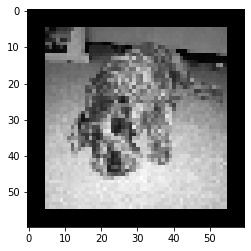

In [163]:
import matplotlib.pyplot as plt
plt.imshow(training_data[5][0],cmap="gray")
plt.show()

#### CNN Architecture 

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
class cnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)      # 1 image, 32 channels, 5*5 krnel default stride=1
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
    
        x = torch.randn(1,60,60).view(-1,1,60,60)
        self.to_linear = None   #auxillary variable to calculate shape of output of conv+max_pool
        self.convs(x)        
        
        self.fc1 = nn.Linear(self.to_linear,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,2)
        
    def convs(self,x):

        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        #x = self.model(x)
        if self.to_linear is None:
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self.to_linear)   #flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)
        


In [165]:
torch.cuda.is_available()

True

In [166]:
torch.backends.cudnn.enabled

True

In [167]:
## Do check for cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU Process")
else:
    device = torch.device("cpu")
    print("CPU Process")

GPU Process


In [168]:
#device = torch.device("cpu")

In [183]:
net = cnet().to(device)   #transferiing class objet to gpu

In [184]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.BCELoss()

In [171]:
#PREPARING TRAINING,TESTING

X = torch.Tensor([i[0] for i in training_data]).view(-1,60,60)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [172]:
training_data[2][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [173]:
y[2]

tensor([1., 0.])

In [174]:
val_ratio = 0.1
val_size = int(len(X)*val_ratio)
print(val_size)

2494


In [175]:
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

In [176]:
print(len(train_X),len(train_y))

22452 22452


In [185]:
def train(net):    
    BATCH_SIZE = 64
    EPOCHS = 20
    for epoch in range(EPOCHS):
        for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,60,60)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X,batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            out = net(batch_X)
            #print(out.size())
            #print(batch_y.size())
            loss = loss_function(out,batch_y)
            loss.backward()
            optimizer.step()
        print("Epoch = "+str(epoch)+", loss = "+str(loss))

In [186]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 60, 60).to(device))[0]  # returns a list, 
            #print(net_out)
            #print(real_class)
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))

In [187]:
train(net)

  2%|▏         | 6/351 [00:00<00:05, 59.02it/s]

Epoch = 0, loss = tensor(0.7096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 57.68it/s]

Epoch = 1, loss = tensor(0.6673, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.27it/s]

Epoch = 2, loss = tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.47it/s]

Epoch = 3, loss = tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.62it/s]

Epoch = 4, loss = tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.89it/s]

Epoch = 5, loss = tensor(0.4278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 59.01it/s]

Epoch = 6, loss = tensor(0.4525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.80it/s]

Epoch = 7, loss = tensor(0.4822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 59.26it/s]

Epoch = 8, loss = tensor(0.8393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.95it/s]

Epoch = 9, loss = tensor(0.3667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 59.63it/s]

Epoch = 10, loss = tensor(0.3118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 59.07it/s]

Epoch = 11, loss = tensor(0.1657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.53it/s]

Epoch = 12, loss = tensor(0.2005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 59.54it/s]

Epoch = 13, loss = tensor(0.2316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.93it/s]

Epoch = 14, loss = tensor(0.0457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 59.54it/s]

Epoch = 15, loss = tensor(0.1417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.22it/s]

Epoch = 16, loss = tensor(0.0721, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 59.33it/s]

Epoch = 17, loss = tensor(0.0111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 6/351 [00:00<00:05, 58.95it/s]

Epoch = 18, loss = tensor(0.0437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|██████████| 351/351 [00:06<00:00, 54.65it/s]

Epoch = 19, loss = tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [188]:
test(net)

100%|██████████| 2494/2494 [00:01<00:00, 1609.16it/s]

Accuracy:  0.775
